# Goal

* Initial testing, assessment, and debugging of SIPSim qSIP data
* **Parameters**
  * 12C control & 13C treatment gradients
  * n-reps = 3 (n-total = 6)
  * % atom excess = 100%
  * % taxa with incorporation = 10%

# Init

In [1]:
import os
import glob
import re
import nestly
%load_ext rpy2.ipython

In [2]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Nestly

* assuming fragments already simulated

In [3]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/'
buildDir = os.path.join(workDir, 'default_rep3')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags.pkl'
genomeIndex = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/genome_index.txt'

# simulation parameters
prefrac_comm_abundance = '1e9'
n_gradient_reps = 3
nprocs = 24

In [30]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('abs', [prefrac_comm_abundance])

## set params
nest.add('percIncorp', [100], create_dir=False)
nest.add('percTaxa', [10], create_dir=False)
nest.add('n_gradient_reps', [n_gradient_reps], create_dir=False)
nest.add('np', [nprocs], create_dir=False)


### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('genomeIndex', [genomeIndex], create_dir=False)

# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [31]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

echo '#-- SIPSim pipeline --#'
echo '# converting fragments to KDE'
SIPSim fragment_KDE \
    {fragFile} \
    > ampFrags_KDE.pkl
    
echo '# adding diffusion'    
SIPSim diffusion \
    ampFrags_KDE.pkl \
    --np {np} \
    > ampFrags_KDE_dif.pkl    

echo '# adding DBL contamination'
SIPSim DBL \
    ampFrags_KDE_dif.pkl \
    --np {np} \
    > ampFrags_KDE_dif_DBL.pkl      
    
echo '# making incorp file'
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  --n_reps 3 \
  > {percTaxa}_{percIncorp}_{n_gradient_reps}.config

echo '# making community file'
!cd $workDir; \
    SIPSim communities \
    --config {percTaxa}_{percIncorp}_{n_gradient_reps}.config \
    {genomeIndex} \
    > comm.txt    

echo '# adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    ampFrags_KDE_dif_DBL.pkl \
    {percTaxa}_{percIncorp}_{n_gradient_reps}.config \
    --comm comm.txt \
    --np {np} \
    > ampFrags_KDE_dif_DBL_inc.pkl
    
echo '# calculating BD shift from isotope incorporation'
SIPSim BD_shift \
    ampFrags_KDE_dif_DBL.pkl \
    ampFrags_KDE_dif_DBL_inc.pkl \
    --np {np} \
    > ampFrags_KDE_dif_DBL_inc_BD-shift.pkl

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    comm.txt > fracs.txt 

echo '# simulating an OTU table'
SIPSim OTU_table \
    ampFrags_KDE_dif_DBL_inc.pkl \
    comm.txt \
    fracs.txt \
    --abs {abs} \
    --np {np} \
    > OTU_abs{abs}.txt
    
echo '# simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_meta.txt
    
    
echo '# Removing control.json file'    
rm -f control.json

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP_rep3/SIPSimRun.sh


In [32]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d qSIP_rep3 --log-file log.txt -j 1

2016-01-18 10:51:23,348 * INFO * Template: ./SIPSimRun.sh
2016-01-18 10:51:23,349 * INFO * [86828] Started ./SIPSimRun.sh in qSIP_rep3/1e9
2016-01-18 11:25:40,332 * INFO * [86828] qSIP_rep3/1e9 Finished with 0


# qSIP

In [185]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('abs', [prefrac_comm_abundance])
nest.add('sim_rep', range(1))

# unvarying params
expDesignFile = os.path.join(buildDir, 'exp_design.txt')
nest.add('expDesignFile', [expDesignFile], create_dir=False)
nest.add('buildDir', [buildDir], create_dir=False)

# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'qSIPRun.sh')

In [186]:
%%writefile $expDesignFile

1	control
2	treatment
3	control
4	treatment
5	control
6	treatment

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/exp_design.txt


In [187]:
%%writefile $bashFile
#!/bin/bash

# qSIP
SIPSim qSIP \
    --reps 3 \
    {buildDir}/{abs}/OTU_abs1e9.txt {buildDir}/{abs}/OTU_abs1e9_PCR_sub.txt \
    > OTU_abs1e9_PCR_sub_qSIP.txt
        
# atom excess
SIPSim qSIP_atomExcess \
    OTU_abs1e9_PCR_sub_qSIP.txt \
    {expDesignFile} \
    > OTU_abs1e9_PCR_sub_qSIP_atom.txt 

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/qSIPRun.sh


In [188]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d default_rep3 --log-file log.txt -j 10

2016-01-19 13:57:27,004 * INFO * Template: ./qSIPRun.sh
2016-01-19 13:57:27,006 * INFO * [98904] Started ./qSIPRun.sh in default_rep3/1e9/7
2016-01-19 13:57:27,007 * INFO * [98905] Started ./qSIPRun.sh in default_rep3/1e9/0
2016-01-19 13:57:27,008 * INFO * [98907] Started ./qSIPRun.sh in default_rep3/1e9/9
2016-01-19 13:57:27,009 * INFO * [98909] Started ./qSIPRun.sh in default_rep3/1e9/8
2016-01-19 13:57:27,010 * INFO * [98911] Started ./qSIPRun.sh in default_rep3/1e9/3
2016-01-19 13:57:27,012 * INFO * [98913] Started ./qSIPRun.sh in default_rep3/1e9/2
2016-01-19 13:57:27,013 * INFO * [98915] Started ./qSIPRun.sh in default_rep3/1e9/1
2016-01-19 13:57:27,014 * INFO * [98917] Started ./qSIPRun.sh in default_rep3/1e9/4
2016-01-19 13:57:27,015 * INFO * [98919] Started ./qSIPRun.sh in default_rep3/1e9/5
2016-01-19 13:57:27,017 * INFO * [98921] Started ./qSIPRun.sh in default_rep3/1e9/6
2016-01-19 13:59:03,402 * INFO * [98919] default_rep3/1e9/5 Finished with 0
2016-01-19 13:59:03,516 * IN

# Analyzing the results

## Plotting total abs abundance (from OTU table)

In [189]:
%%R -i buildDir -i prefrac_comm_abundance 

OTU_file = file.path(buildDir, prefrac_comm_abundance, 'OTU_abs1e9.txt')

df.OTU = read.delim(OTU_file, sep='\t') %>%
    group_by(library, fraction, BD_mid) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = library %>% as.character) 

df.OTU %>% head(n=3)

Source: local data frame [3 x 4]

  library    fraction BD_mid total_count
    (chr)      (fctr)  (dbl)       (int)
1       1 1.660-1.663  1.661       94176
2       1 1.663-1.665  1.664       62854
3       1 1.665-1.671  1.668      200310


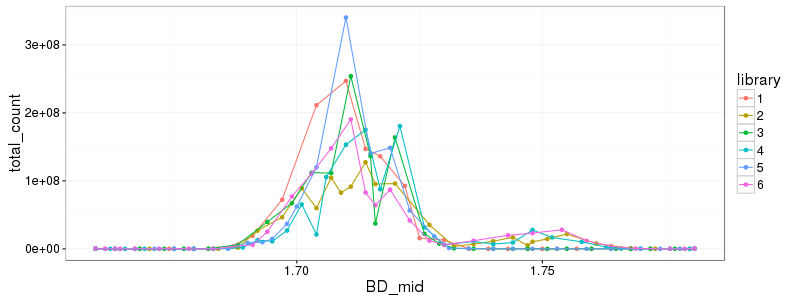

In [190]:
%%R -w 800 -h 300

ggplot(df.OTU, aes(BD_mid, total_count, color=library)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## qPCR values

In [191]:
qPCR_files = !find $buildDir -maxdepth 3 -name "OTU_abs1e9_PCR_sub_qSIP.txt"
qPCR_files

['/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/7/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/0/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/9/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/8/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/3/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/2/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/1/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/4/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/5/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/6/OTU_abs1e9

In [192]:
%%R -i qPCR_files
# loading files
df = list()
for (x in qPCR_files){
    f = gsub('/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/([0-9.]+)/.+', '\\1', x)
    df[[f]] = read.delim(x, sep='\t') %>%
        distinct(library, fraction) %>%
        select(-taxon) %>%
        as.data.frame()
    }
df = do.call('rbind', df)
df$file = gsub('\\.[0-9]+$', '', rownames(df))
rownames(df) = 1:nrow(df)
df = df %>%
    mutate(exp_design = ifelse(library %% 2 == 0, 'treatment', 'control'),
           library = library %>% as.character,
           file = file %>% as.numeric)
df %>% head(n=3)

  library   fraction BD_min BD_mid BD_max count  rel_abund total_qPCR_copies
1       1 -inf-1.660   -Inf  1.659  1.659   291 0.01319010            363467
2       2 -inf-1.660   -Inf  1.659  1.659   209 0.01315458             77183
3       3 -inf-1.660   -Inf  1.659  1.659   269 0.01264217            322810
  prop_abs_abund file exp_design
1           4794    7    control
2             33    7  treatment
3            148    7    control


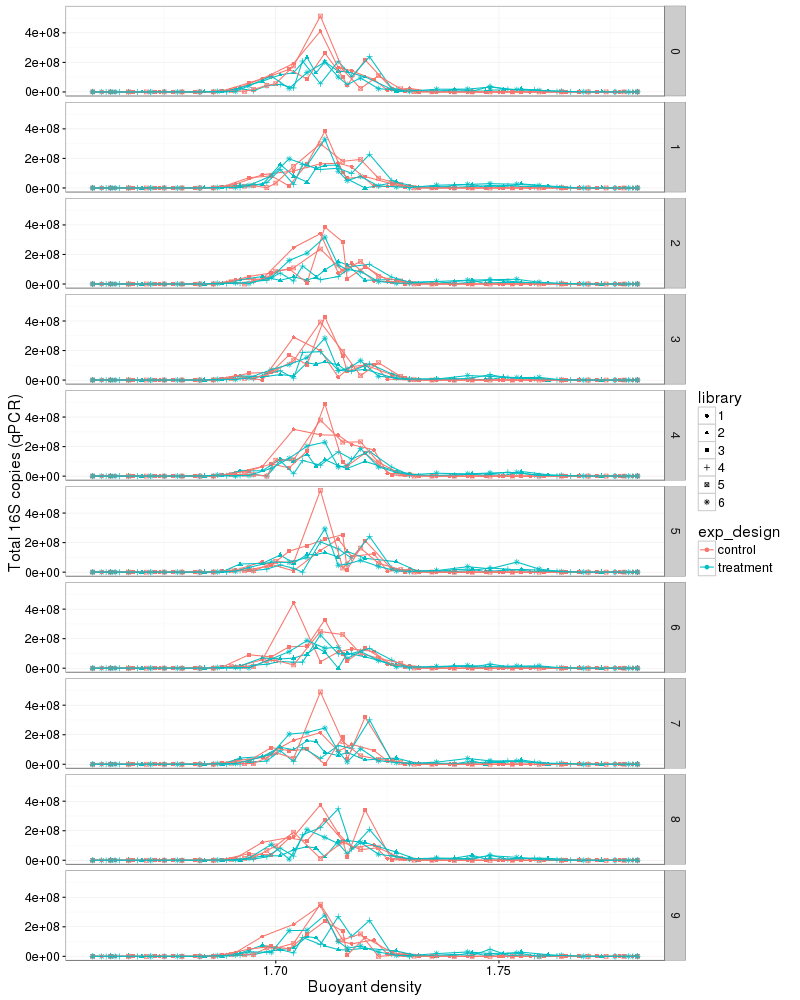

In [193]:
%%R -w 800 -h 1000

ggplot(df, aes(BD_mid, total_qPCR_copies, color=exp_design, group=library, shape=library)) +
    geom_point() +
    geom_line() +
    facet_grid(file ~ .) +
    #scale_y_log10() +
    labs(x = 'Buoyant density', y='Total 16S copies (qPCR)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Scaling to proportion of total (as in Hungate et al., 2015)

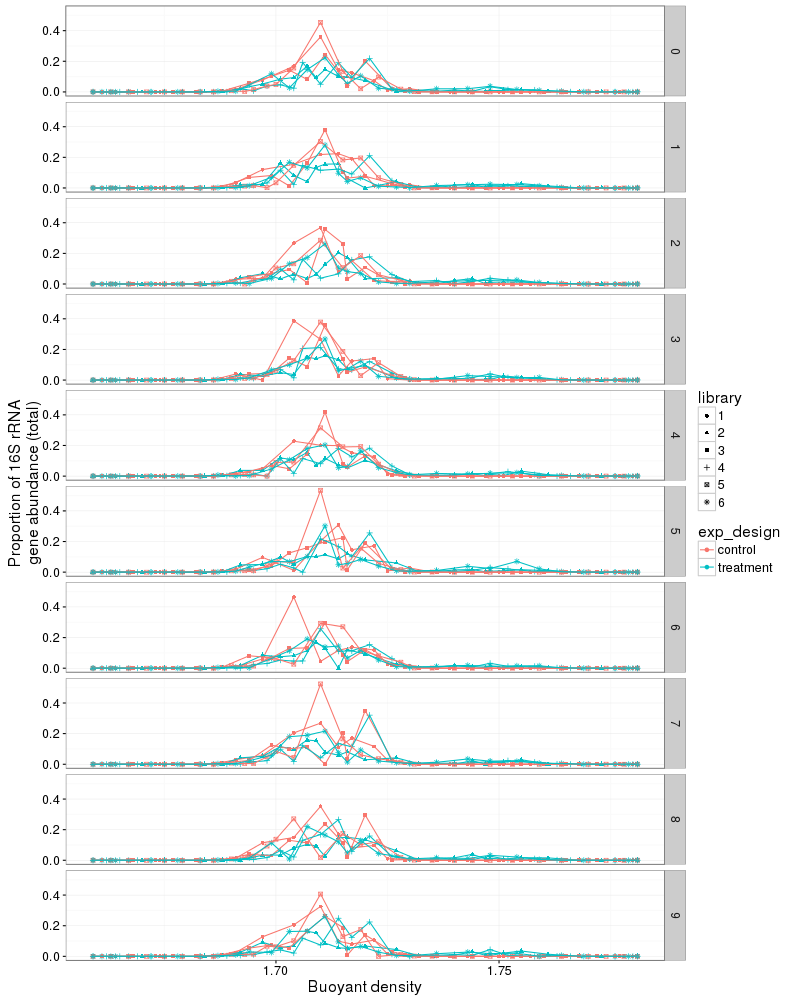

In [194]:
%%R -w 800 -h 1000

df = df %>%
    group_by(file, library) %>%
    mutate(frac_total_qPCR_copies = total_qPCR_copies / sum(total_qPCR_copies)) %>%
    ungroup() 

ggplot(df, aes(BD_mid, frac_total_qPCR_copies, color=exp_design, group=library, shape=library)) +
    geom_point() +
    geom_line() +
    facet_grid(file ~ .) +
    labs(x = 'Buoyant density', y='Proportion of 16S rRNA\ngene abundance (total)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Plotting % atom excess

In [195]:
qPCR_files = !find $buildDir -maxdepth 3 -name "OTU_abs1e9_PCR_sub_qSIP_atom.txt"
qPCR_files

['/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/7/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/0/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/9/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/8/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/3/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/2/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/1/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/4/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/5/OTU_abs1e9_PCR_sub_qSIP_atom.txt',
 '/home/nick/notebook/SIPSim/dev/bac_

In [196]:
%%R -i qPCR_files
# loading files

df.atom = list()
for (x in qPCR_files){
    f = gsub('/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/([0-9.]+)/.+', '\\1', x)
    df.atom[[f]] = read.delim(x, sep='\t') 
    }
df.atom = do.call('rbind', df.atom)
df.atom$file = gsub('\\.[0-9]+$', '', rownames(df.atom))
rownames(df.atom) = 1:nrow(df.atom)
df.atom %>% head(n=3)

                                 taxon  control treatment     BD_diff
1       Acaryochloris_marina_MBIC11017 1.723477  1.718754 -0.00472277
2 Acetobacter_pasteurianus_IFO_3283-03 1.728878  1.718750 -0.01012790
3       Acetobacterium_woodii_DSM_1030 1.733157  1.711209 -0.02194746
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess file
1  0.6477225   308.0123         317.6638     307.1682          -0.08647893    7
2  0.7028384   308.0396         317.6636     306.2351          -0.18541771    7
3  0.7464959   308.0613         317.6635     304.1602          -0.40175091    7


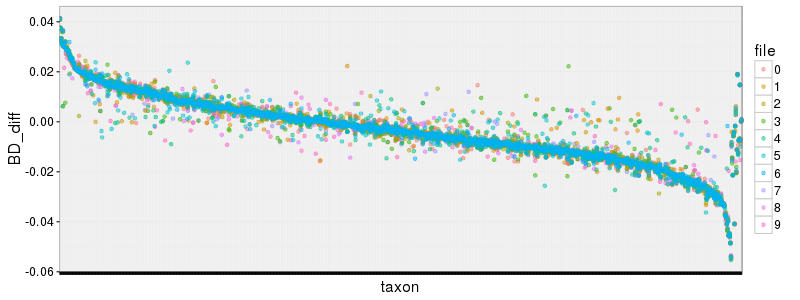

In [197]:
%%R -w 800 -h 300

df.atom$taxon = reorder(df.atom$taxon, -df.atom$BD_diff)

ggplot(df.atom, aes(taxon, BD_diff, color=file)) +
    geom_point(alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
    )

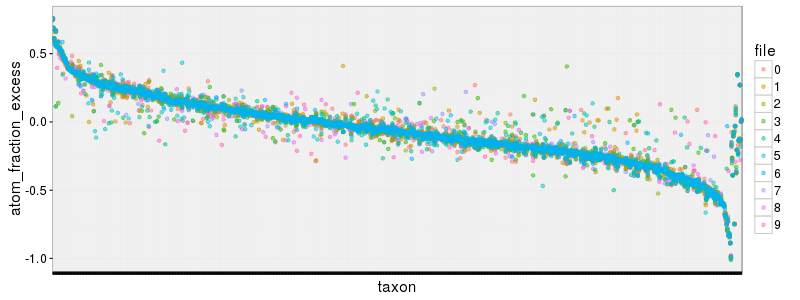

In [198]:
%%R -w 800 -h 300

df.atom$taxon = reorder(df.atom$taxon, -df.atom$atom_fraction_excess)

ggplot(df.atom, aes(taxon, atom_fraction_excess, color=file)) +
    geom_point(alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
    )

# Comparing BD shift between qSIP and known

`SIPSim BD_shift` **vs** `SIPSim qSIP_atomExcess`